In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Visualizing Large  / High Dimensional Datasets
<!-- requirement: small_data/fha_by_tract.csv -->
<!-- requirement: small_data/bustime_micro.csv -->

## Unique Concerns with Large Data

When attempting to visualize large or high-dimensional datasets, our concerns are twofold:

1. (you-facing) Effectively computing the visualization in code.
2. (end-user-facing) Effectively conveying the key points to viewers.

Both of these concerns stem from the same issue: the dataset simply contains tons of information, and it's your job to separate the signal from the noise both for reasons of computational tractability and visualization efficacy.

There are a couple ways ways to reduce the amount of data your visualization relies on. We'll discuss

- preprocessing our dataset (eg subsampling, PCA)
- filtering or querying in realtime for subsets/groups of the data (assuming you have a powerful enough backend)

## PCA And Dimensionality Reduction

As a technique for dimensionality reduction, [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) is very useful (see Module 3 for more info on PCA). One way we can use this to our advantage is by mapping high-dimensional data into 2D space for quick and easy visualizations. 

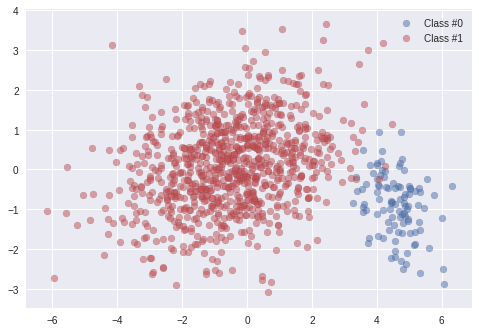

In [3]:
# https://github.com/glemaitre/UnbalancedDataset/blob/master/notebook/Notebook_UnbalancedDataset.ipynb
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification


# Generate some data
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9],
                           n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1,
                           n_samples=1000, random_state=10)

# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components = 2)

# Fit and transform x to visualise inside a 2D feature space
x_vis = pca.fit_transform(X)

# Plot the original data
# Plot the two classes
palette = sns.color_palette()
plt.scatter(x_vis[y==0, 0], x_vis[y==0, 1], label="Class #0", alpha=0.5, 
            edgecolor='#262626', facecolor=palette[0], linewidth=0.15)
plt.scatter(x_vis[y==1, 0], x_vis[y==1, 1], label="Class #1", alpha=0.5, 
            edgecolor='#262626', facecolor=palette[2], linewidth=0.15)

plt.legend()
plt.show()

*Question*: What are the axis labels? ANS: linear combination of input features, you can look at transformation matrix, but maybe do not make sense to you.

This is a fairly contrived example. In general, further explanation is likely needed if you decide to use PCA or other dimensionality-reduction techniques to visualize some subset or aggregate of your data. For a more interesting application, check out this visualization of word2vec feature space clustering ([github](http://github.com/ronxin/wevi)) ([online demo](http://bit.ly/wevi-online)) (also see [this paper](https://arxiv.org/pdf/1402.3722.pdf)).

Two other dimensionality reduction alternatives: [MDS](https://en.wikipedia.org/wiki/Multidimensional_scaling) and [Denoising Autoencoders](https://en.wikipedia.org/wiki/Autoencoder#Denoising_Autoencoder).

## Using Pandas to filter and downsample for visualization

### High-level considerations

When visualizing data, it usually makes litte sense to try to convey gigabytes' (or more) worth of information to an end-user (unless your end-user is [Adrian Veidt](http://i46.tinypic.com/1qqtmw.jpg)). Plus, this slows down computation on the backend. A little pre-processing goes a long way toward addressing both issues 1) and 2) from the beginning of this notebook.

Some considerations:
- When downsampling timeseries data, make sure that your sample is sufficiently representative to include time-based effects. Can you think of some examples?
- Consider visualizing a deliberate subset (not via sampling) of the data. Using some subset, can you successfully reinforce the message you're trying to convey? Do you want to provide another visualization to compare/contrast with the rest of the data?


### Tips and tricks from the field in pandas

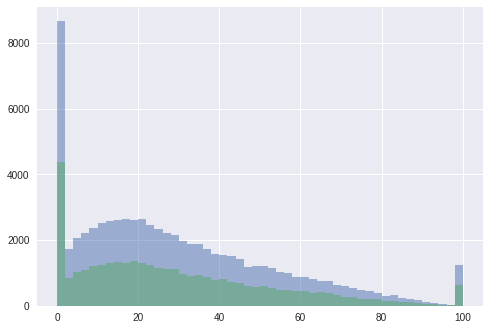

In [4]:
import pandas as pd

names =["State_Code", "County_Code", "Census_Tract_Number", "NUM_ALL", "NUM_FHA", "PCT_NUM_FHA", "AMT_ALL", "AMT_FHA", "PCT_AMT_FHA"]
df = pd.read_csv('small_data/fha_by_tract.csv', names=names)  ## Loading a CSV file, without a header (so we have to provide field names)

"""
Borrowed from the Pandas notebook (see module 1 for more info).
- Notice how the distribution of the two histograms is the same. 
- If you don't care about raw counts, sampling speeds up visualization
while conveying the exact same information.
"""
df['PCT_AMT_FHA'].hist(bins=50, alpha=0.5)
df['PCT_AMT_FHA'].sample(frac=.5).hist(bins=50, alpha=0.5)

In the visualization miniproject, we provide a pre-cleaned ~80MB dataset. We did a fair bit of processing from a week's worth of raw CSV bus time data (about 300MB each). If you'd like to try your hand at downsampling yourself, we've provided some of that code here, highlighting the techniques we used to make the data Heroku-sized.

In [5]:
from datetime import datetime

# the raw MTA data actually needs a slightly different parser, if you copy this for your own uses
date_parser=lambda u: pd.datetime.strptime(u, "%Y-%m-%d %H:%M:%S")
CSV_FILENAMES=["small_data/bustime_micro.csv"]
archive = pd.concat([pd.read_csv(fname,  
                                 parse_dates=True,
                                 date_parser=date_parser,
                                 index_col=0) for fname in CSV_FILENAMES])
#query and clean
live_archive = archive[archive.block_assigned > 0] # "assigned" to a route

#throw away trips with <15 reports, probably not real
good_trips_only = live_archive.groupby(live_archive.trip_id).filter(lambda group: len(group) > 15)

In [ ]:
## join to trip data and filter to manhattan only (ie look at a subset)
## Note the "reset_index" to deal with merging index complications.
# good_trips_only.reset_index(inplace=True)
# merged = good_trips_only.merge('trips.txt', on='trip_id', left_index=True)
# merged.sort('timestamp', inplace=True)
# merged.set_index('timestamp')
# manhattan_only = merged[merged.route_id.str.contains("^M")]

In [6]:
def get_intervals_for_archive():
    intervals = [(datetime(2015, 9, d, h, m),
                   datetime(2015, 9, d, h, m + 2))
                for h in range(0, 24)
                for m in range(0, 60, 15)
                for d in range(13, 21)]
    return intervals

#exercise: any better solution for this?
subsampled_dataset = pd.concat([good_trips_only[lower:upper]
                                for lower, upper in get_intervals_for_archive()])

We can still load 7 days' worth of data into memory and preprocess without too much trouble. What if we have a dataset that won't fit into RAM?

Pandas has a solution for that: `skiprows`

In [7]:
import pandas as pd
 
f = "small_data/fha_by_tract.csv"

with open(f) as in_file:
    num_lines = sum(1 for l in in_file)

n = 10
# make sure line 0 is not included if you have a header!
skip_list = [x for x in range(1, num_lines) if x % n != 0]

# Read the data
%time data1 = pd.read_csv(f, skiprows=skip_list)

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 24.6 ms


In [8]:
# a generator will also work. note it is slower.
skip_gen = (x for x in range(1, num_lines) if x % n != 0)

%time data2 = pd.read_csv(f, skiprows=skip_gen)

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 34.5 ms


See the Advanced D3 notebook for some notes on live-querying a backend using AJAX.

*Copyright &copy; 2016 The Data Incubator.  All rights reserved.*